In [1]:
# Import dataset

import pandas as pd
import warnings
import sys  

PROJECT_FOLDER = '/home/ricardo/coding/data-science/projects/predict_value_change_from_fm_data/'

sys.path.insert(0, PROJECT_FOLDER)
warnings.filterwarnings('ignore')

fm20_dataset = pd.read_csv(PROJECT_FOLDER + "datasets/datafm20.csv")
transfermarkt_players_dataset = pd.read_csv(PROJECT_FOLDER + "datasets/players.csv")
transfermarkt_valuations_dataset = pd.read_csv(PROJECT_FOLDER + "datasets/player_valuations.csv")

In [2]:
# Prepare dataset - merge fm20_df and less_28_players

# Use only players with less than 28 yo

transfermarkt_base_players_df = transfermarkt_players_dataset [:]
transfermarkt_base_players_df.query("last_season >= 2021 & date_of_birth >= '1992-01-01' & position != 'Goalkeeper'", inplace=True)
transfermarkt_base_players_df.sort_values(by='market_value_in_gbp', ascending=False, inplace=True)

fm20_base_players_df = fm20_dataset.query("Age <= 27 & `Best Pos` != 'GK'")
fm20_base_players_df.sort_values(by='Value', ascending=False, inplace=True)

In [11]:
# Map country_of_citizenship (Transfermarkt) to country codes (FM20)

from utils import name_to_id

fm20_name_nation_mapping = fm20_dataset.groupby('Nation').head()[['Name', 'Nation']]
fm20_name_nation_mapping['Transfermarkt_Name'] = fm20_name_nation_mapping['Name'].apply(name_to_id).apply(lambda x: x.replace('-scaron-', 's'))

transfermarkt_name_nation_mapping = transfermarkt_base_players_df[['name', 'country_of_citizenship']]

player_nationalities_mapping = fm20_name_nation_mapping.merge(transfermarkt_name_nation_mapping, left_on='Transfermarkt_Name', right_on='name')
player_nationalities_mapping.drop_duplicates(subset='Nation', inplace=True)

fm20_base_players_df = fm20_base_players_df.merge(player_nationalities_mapping[['Nation', 'country_of_citizenship']], on='Nation')

In [12]:
# Map position (Transfermarkt) to Best Pos (FM20)

from utils import POSITION_MAPPING

transfermarkt_base_players_df['FM_Pos'] = transfermarkt_base_players_df['position'].apply(lambda x: x[0])

fm20_base_players_df['Transfermarkt_Pos'] = fm20_base_players_df['Best Pos'].map(POSITION_MAPPING)

In [13]:
# Map name (Transfermarkt) to Name (FM20)

fm20_base_players_df['Transfermarkt_Name'] = fm20_base_players_df['Name'].apply(name_to_id).apply(lambda x: x.replace('-scaron-', 's'))

In [19]:
# Merge dataframes

transfermarkt_fm20_merged_df = fm20_base_players_df.merge(transfermarkt_base_players_df, left_on=['Transfermarkt_Name', 'country_of_citizenship', 'Transfermarkt_Pos'], right_on=['name', 'country_of_citizenship', 'FM_Pos'])

transfermarkt_fm20_merged_df.drop_duplicates(subset=['Transfermarkt_Name', 'country_of_citizenship', 'FM_Pos'], inplace=True)

In [20]:
# Insert target values (valuation now vs valuations 2020)

transfermarkt_fm20_merged_df['value_2022'] = transfermarkt_fm20_merged_df['market_value_in_gbp']

player_values_2020 = transfermarkt_valuations_dataset.query("date >= '2019-07-01' & date <= '2020-12-31'").sort_values(by='date', ascending=True).drop_duplicates(subset='player_id')

player_values_2020['value_2020'] = player_values_2020['market_value']

players_with_values = transfermarkt_fm20_merged_df.merge(player_values_2020, on='player_id')

players_with_values['value_diff'] = players_with_values['value_2022'] - players_with_values['value_2020']

<AxesSubplot:>

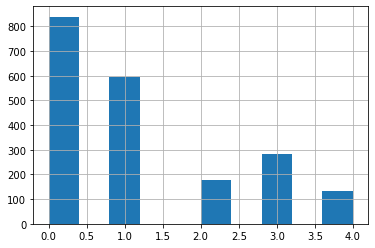

In [81]:
# Prepare df for stratify

import numpy as np

value_bins = [-np.inf, 0, 1000000, 2500000, 10000000, np.inf]

players_with_values['value_cat'] = pd.cut(players_with_values["value_diff"], bins=value_bins, labels=range(len(value_bins)-1))

players_with_values['value_cat'].hist()

In [82]:
# Create test set

players_for_analysis = players_with_values[:]

players_for_analysis.dropna(subset=['value_cat'], inplace=True)

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(players_for_analysis, players_for_analysis['value_cat'], test_size=0.2, random_state=42, stratify=players_for_analysis['value_cat'])

In [83]:
# Select features of the dataset we will work with

from utils import PLAYER_ATTR

features = PLAYER_ATTR + ['Age', 'Preferred Foot', 'Best Pos', 'Nation', 'Based']
player_features = players_for_analysis[features]

In [84]:
# Revert to clean training set

players = x_train.drop('value_cat', axis=1)
players_labels = x_train['value_cat'].copy()

In [85]:
# Custom Nation transformer

from sklearn.base import BaseEstimator, TransformerMixin

class NationToRank(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        fifa_wr = pd.read_csv(PROJECT_FOLDER + "datasets/fifa_ranking-2021-05-27.csv")
        nation_encoder = fifa_wr.query('rank_date == "2020-10-22"')[['rank', 'country_abrv']]
        max_rank = nation_encoder['rank'].max() + 1
        X['Nation_rank'] = 1 - (X['Nation'].map(nation_encoder.set_index('country_abrv')['rank']).fillna(max_rank) / max_rank)
        X.drop('Nation', axis=1, inplace=True)
        return X

In [86]:
# Custom Based transformer

from sklearn.base import BaseEstimator, TransformerMixin

class BasedToRank(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        based_encoder = players_with_values.groupby('Based').sum().rank(ascending=True, method='first')
        max_rank = based_encoder['value_2020'].max()
        X['Based_rank'] = (X['Based'].map(based_encoder['value_2020']).fillna(max_rank) / max_rank)
        X.drop('Based', axis=1, inplace=True)
        return X

In [87]:
# Using transformation pipelines

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from utils import PLAYER_ATTR, apply_mean_attribute_list

players = x_train.drop('Value', axis=1)

num_attribs = PLAYER_ATTR + ['Age', 'M+P']
cat_attribs = ['Preferred Foot', 'Best Pos']

apply_mean_attribute_list(players, 'PHY', ['Acc', 'Pac', 'Sta', 'Str', 'Agi', 'Bal', 'Jum', 'Nat'])
apply_mean_attribute_list(players, 'MEN', ['Wor', 'Vis', 'Tea', 'Pos', 'OtB', 'Ldr', 'Fla', 'Det', 'Dec', 'Cnt', 'Cmp', 'Bra', 'Ant', 'Agg'])
apply_mean_attribute_list(players, 'M+P', ['MEN', 'PHY'])

full_pipeline = ColumnTransformer([
    ("num", StandardScaler(), num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
    ("nat", NationToRank(), ['Nation']),
    ("bas", BasedToRank(), ['Based'])
])

players_prepared = full_pipeline.fit_transform(players)

In [91]:
# Select and train model
## RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier

value_predictor = RandomForestClassifier(max_depth=None, n_estimators = 100, random_state = 42)
value_predictor.fit(players_prepared, players_labels)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [92]:
# Error analysis

from sklearn.model_selection import cross_val_predict

value_predictions = cross_val_predict(value_predictor, players_prepared, players_labels, cv=5)

<AxesSubplot:>

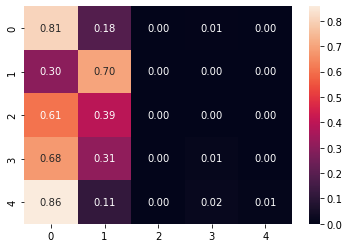

In [93]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(players_labels, value_predictions)
conf_mx = conf_mx.astype('float') / conf_mx.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mx, annot=True, fmt='.2f')

<BarContainer object of 58 artists>

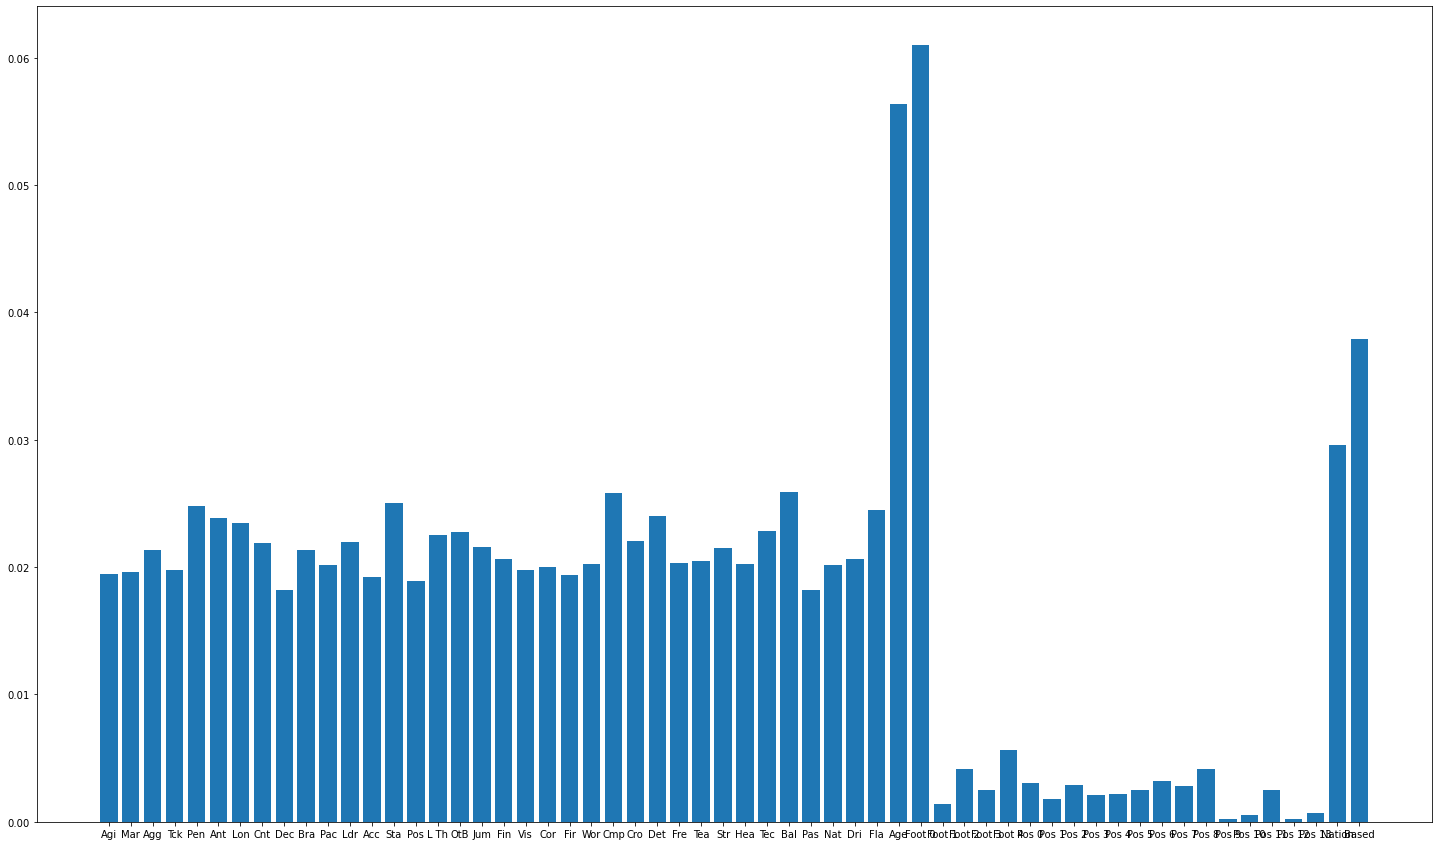

In [104]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (25,15)

new_features = PLAYER_ATTR + ['Age'] + [f'Foot {_}' for _ in range(5)] + [f'Pos {_}' for _ in range(14)] + ['Nation', 'Based']
plt.bar(new_features, value_predictor.feature_importances_)

In [102]:
evaluate_outliers = players[['Name', 'Division', 'Based']]
evaluate_outliers['Value'] = players_df['Value']
evaluate_outliers['Val_dif'] = value_predictions - players_labels.astype(np.int8)
